# STOCK PRICE PREDICTION MODEL

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# Load stock data
ticker = "AAPL"
data = yf.download(ticker, start="2015-01-01", end="2023-01-01")
data['Close'] = data['Adj Close']
data = data[['Close']]

[*********************100%***********************]  1 of 1 completed


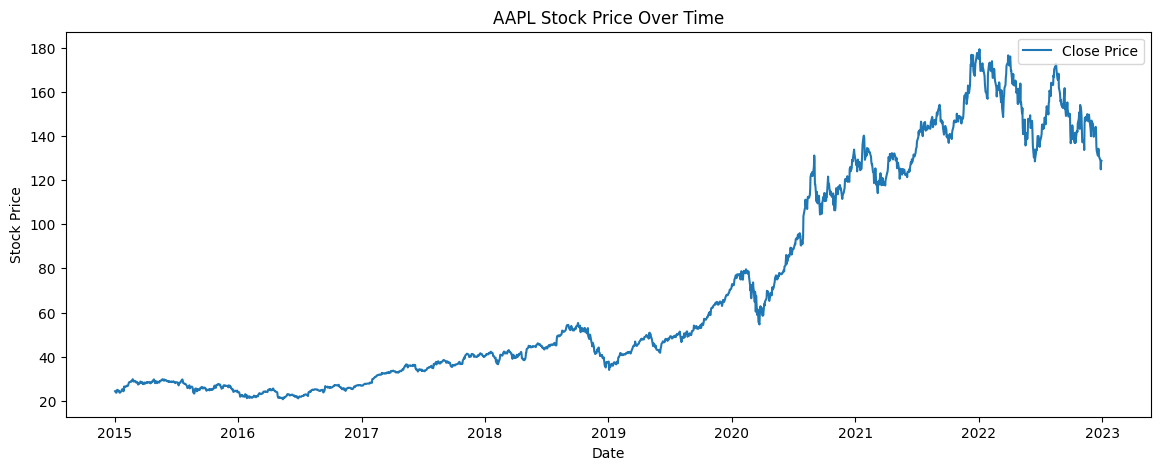

In [3]:
# Plot stock closing prices
plt.figure(figsize=(14, 5))
plt.plot(data['Close'], label="Close Price")
plt.title(f"{ticker} Stock Price Over Time")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

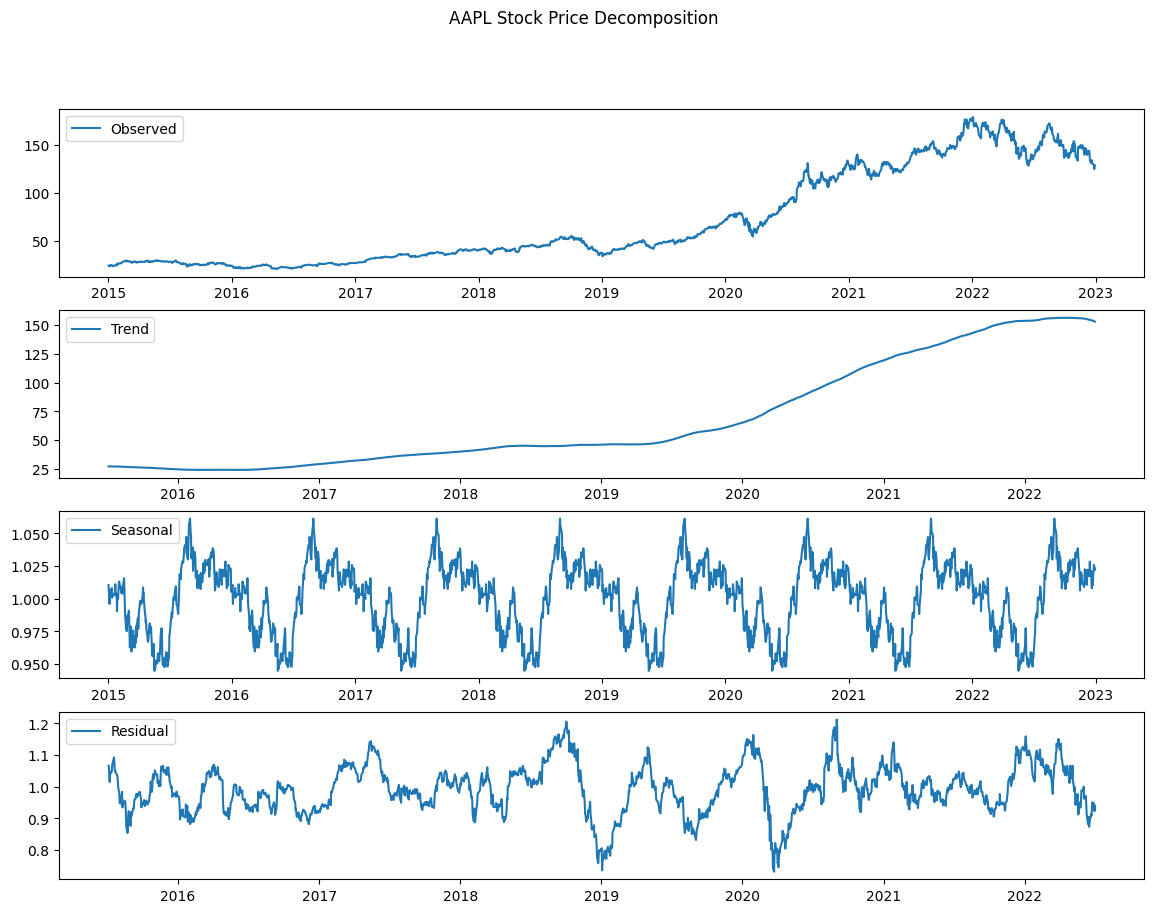

In [4]:
# Decompose time series into trend, seasonal, and residuals
decomposition = seasonal_decompose(data['Close'], model='multiplicative', period=252)
plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend(loc='upper left')
plt.suptitle(f"{ticker} Stock Price Decomposition")
plt.show()

In [5]:
# Preprocess data for LSTM model
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [6]:
# Define training and test data
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [7]:
# Prepare sequences for LSTM
def create_sequences(dataset, sequence_length):
    X, y = [], []
    for i in range(len(dataset) - sequence_length):
        X.append(dataset[i:i + sequence_length, 0])
        y.append(dataset[i + sequence_length, 0])
    return np.array(X), np.array(y)

sequence_length = 60
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

In [8]:

# Reshape for LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Build LSTM model

In [15]:


model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
49/49 [==============================] - 8s 53ms/step - loss: 0.0097
Epoch 2/100
49/49 [==============================] - 3s 54ms/step - loss: 3.6364e-04
Epoch 3/100
49/49 [==============================] - 3s 54ms/step - loss: 3.2606e-04
Epoch 4/100
49/49 [==============================] - 3s 52ms/step - loss: 2.9472e-04
Epoch 5/100
49/49 [==============================] - 3s 53ms/step - loss: 2.9288e-04
Epoch 6/100
49/49 [==============================] - 3s 54ms/step - loss: 3.0660e-04
Epoch 7/100
49/49 [==============================] - 3s 53ms/step - loss: 2.9060e-04
Epoch 8/100
49/49 [==============================] - 3s 57ms/step - loss: 2.8882e-04
Epoch 9/100
49/49 [==============================] - 3s 54ms/step - loss: 3.0378e-04
Epoch 10/100
49/49 [==============================] - 3s 68ms/step - loss: 2.7676e-04
Epoch 11/100
49/49 [==============================] - 4s 74ms/step - loss: 2.6450e-04
Epoch 12/100
49/49 [==============================] - 4s 77ms/step 

In [16]:
# Predict and inverse transform predictions
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
real_stock_price = scaler.inverse_transform(test_data[sequence_length:])

11/11 [==============================] - 2s 22ms/step


In [17]:
# Calculate accuracy scores
mse = mean_squared_error(real_stock_price, predicted_stock_price)
r2 = r2_score(real_stock_price, predicted_stock_price)
print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Mean Squared Error: 10.504670542138754
R^2 Score: 0.931829114334004


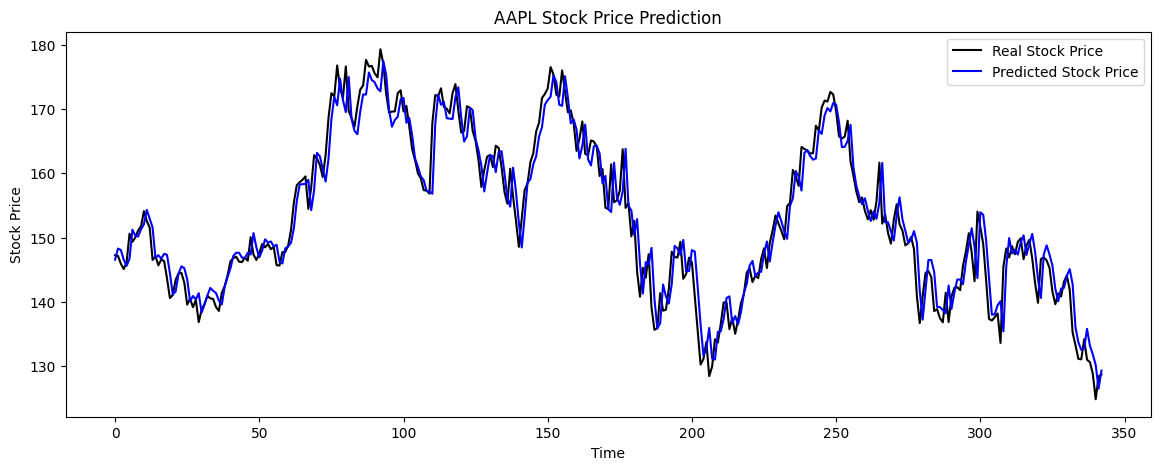

In [18]:
# Plot predictions vs real prices
plt.figure(figsize=(14, 5))
plt.plot(real_stock_price, color="black", label="Real Stock Price")
plt.plot(predicted_stock_price, color="blue", label="Predicted Stock Price")
plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

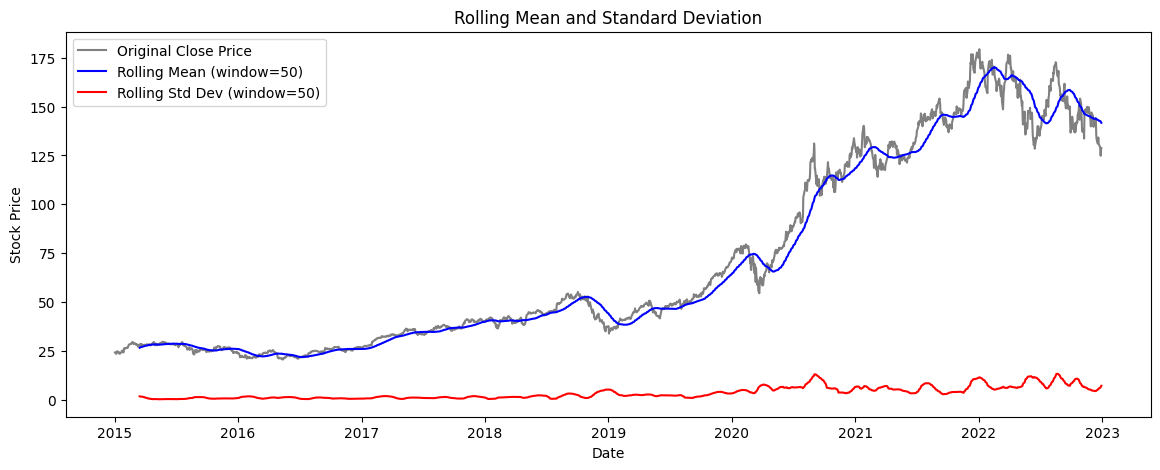

In [19]:

# Rolling Mean and Standard Deviation
window = 50
rolling_mean = data['Close'].rolling(window=window).mean()
rolling_std = data['Close'].rolling(window=window).std()
plt.figure(figsize=(14, 5))
plt.plot(data['Close'], color="gray", label="Original Close Price")
plt.plot(rolling_mean, color="blue", label=f"Rolling Mean (window={window})")
plt.plot(rolling_std, color="red", label=f"Rolling Std Dev (window={window})")
plt.title("Rolling Mean and Standard Deviation")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

# ANOMALY PATTERN DETECTION MODEL

In [20]:
# Anomaly Detection with Isolation Forest
iso_forest = IsolationForest(contamination=0.01)
data['Anomaly'] = iso_forest.fit_predict(data[['Close']])

C:\Users\Navya\AppData\Local\Temp\ipykernel_3256\3121162902.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Anomaly'] = iso_forest.fit_predict(data[['Close']])


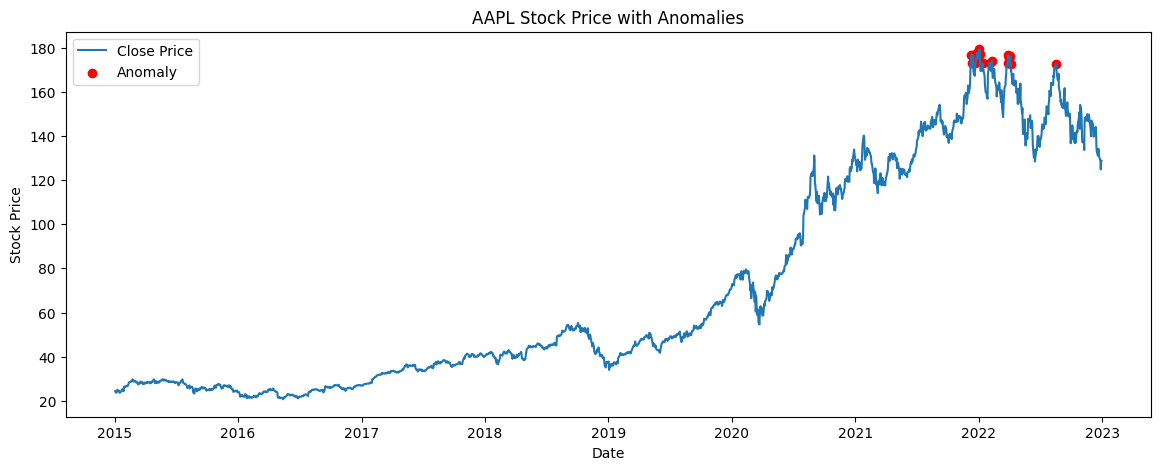

In [21]:
# Plot anomalies
anomalies = data[data['Anomaly'] == -1]
plt.figure(figsize=(14, 5))
plt.plot(data['Close'], label="Close Price")
plt.scatter(anomalies.index, anomalies['Close'], color="red", label="Anomaly")
plt.title(f"{ticker} Stock Price with Anomalies")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

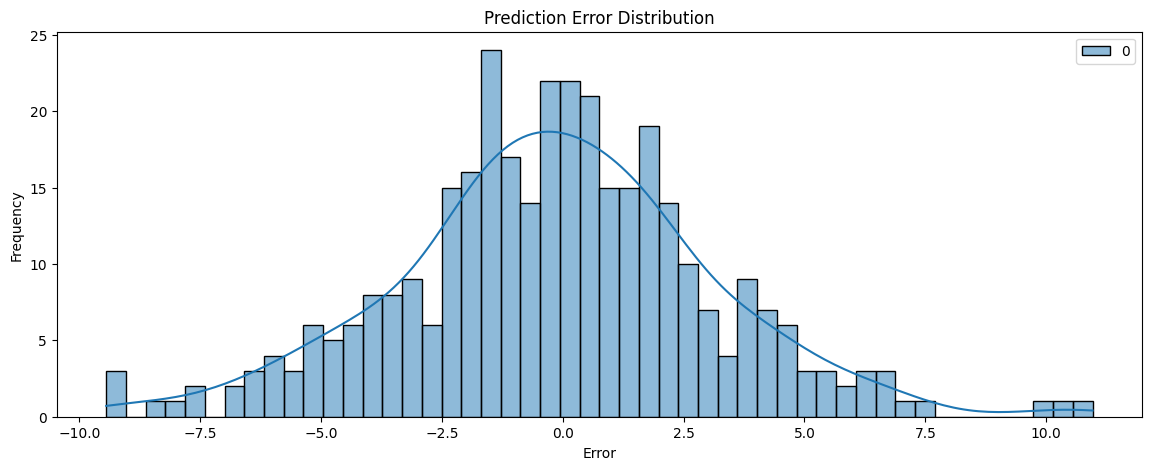

In [22]:

# Error distribution for LSTM predictions
error = real_stock_price - predicted_stock_price
plt.figure(figsize=(14, 5))
sns.histplot(error, kde=True, color="purple", bins=50)
plt.title("Prediction Error Distribution")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()

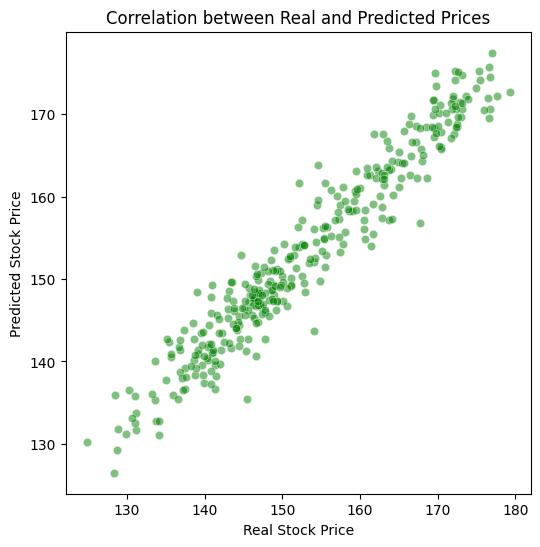

In [23]:

# Correlation between actual and predicted prices
plt.figure(figsize=(6, 6))
sns.scatterplot(x=real_stock_price.flatten(), y=predicted_stock_price.flatten(), color="green", alpha=0.5)
plt.title("Correlation between Real and Predicted Prices")
plt.xlabel("Real Stock Price")
plt.ylabel("Predicted Stock Price")
plt.show()

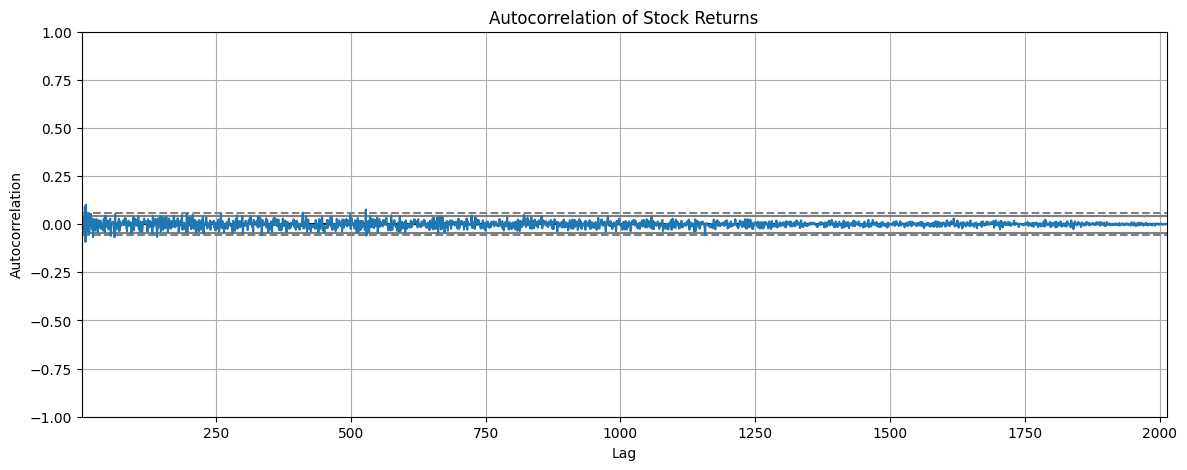

In [24]:
# Autocorrelation of the stock returns
returns = data['Close'].pct_change().dropna()
plt.figure(figsize=(14, 5))
pd.plotting.autocorrelation_plot(returns)
plt.title("Autocorrelation of Stock Returns")
plt.show()

# INVESTMENT ANALYSIS 

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
import datetime as dt

In [26]:
# Load stock data for the last 6 months
def load_recent_data(ticker):
    end_date = dt.datetime.today()
    start_date = end_date - dt.timedelta(days=180)
    data = yf.download(ticker, start=start_date, end=end_date)
    data['Close'] = data['Adj Close']
    return data[['Close']]

In [27]:
# Function to determine if it's a good time to invest
def should_invest(data):
    # Moving averages
    short_window = 50
    long_window = 200
    data['50_MA'] = data['Close'].rolling(window=short_window).mean()
    data['200_MA'] = data['Close'].rolling(window=long_window).mean()

    # Check trend direction
    if data['50_MA'].iloc[-1] > data['200_MA'].iloc[-1]:
        ma_trend = "upward"
    else:
        ma_trend = "downward"

    # Calculate price volatility (standard deviation of returns)
    returns = data['Close'].pct_change().dropna()
    volatility = returns.std()

    # Predict the trend using LSTM
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

    # Create sequences for LSTM
    sequence_length = 60
    X_test, y_test = create_sequences(scaled_data, sequence_length)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Make predictions
    predicted_price = model.predict(X_test)
    predicted_price = scaler.inverse_transform(predicted_price)

    # Trend analysis based on the model's prediction for the next period
    recent_trend = "upward" if predicted_price[-1] > predicted_price[-10] else "downward"

    # Investment recommendation logic
    if ma_trend == "upward" and recent_trend == "upward" and volatility < 0.02:
        recommendation = "Based on recent performance and trend analysis, it may be a good time to invest."
    else:
        recommendation = "Based on recent performance and trend analysis, it may not be a good time to invest."

    return recommendation

In [28]:
# Load recent data
ticker = "AAPL"
recent_data = load_recent_data(ticker)

[*********************100%***********************]  1 of 1 completed


In [29]:
# Run investment analysis
investment_advice = should_invest(recent_data)
print(investment_advice)

3/3 [==============================] - 0s 22ms/step
Based on recent performance and trend analysis, it may not be a good time to invest.


C:\Users\Navya\AppData\Local\Temp\ipykernel_3256\906679366.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['50_MA'] = data['Close'].rolling(window=short_window).mean()
C:\Users\Navya\AppData\Local\Temp\ipykernel_3256\906679366.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['200_MA'] = data['Close'].rolling(window=long_window).mean()


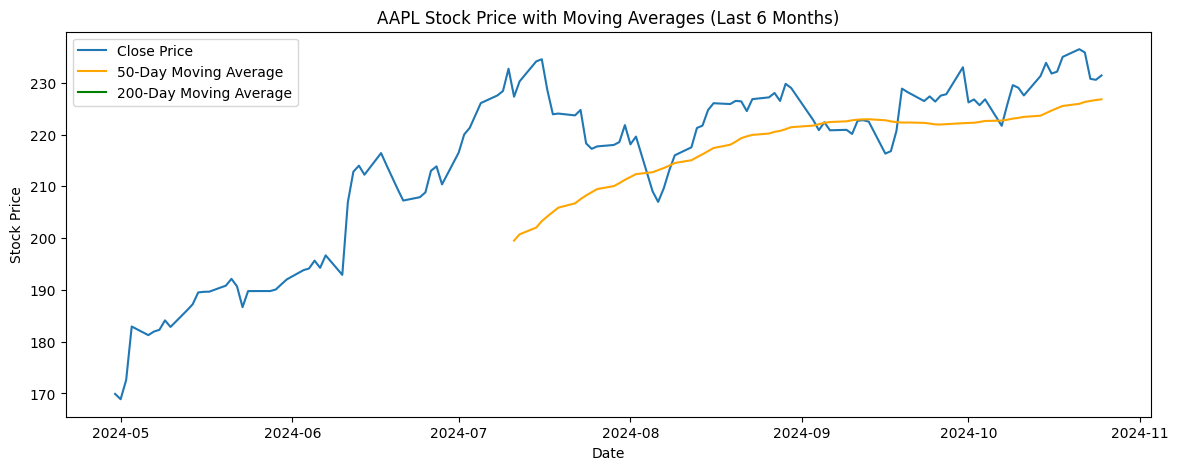

In [30]:
# Plot recent closing price with moving averages
plt.figure(figsize=(14, 5))
plt.plot(recent_data['Close'], label="Close Price")
plt.plot(recent_data['50_MA'], label="50-Day Moving Average", color="orange")
plt.plot(recent_data['200_MA'], label="200-Day Moving Average", color="green")
plt.title(f"{ticker} Stock Price with Moving Averages (Last 6 Months)")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()